## FNDAHW09

## 1，运用sklearn中的 GradientBoostingClassifier构建GBDT模型，需要对参数n_estimator， max_depth， min_samples_split，min_samples_leaf，max_features， Subsample进行调优

In [2]:
# %load GBDT.py
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pylab as plt
from sklearn.metrics import roc_auc_score

def Missingrate_Column(df, col):
    '''
    :param df:
    :param col:
    :return:
    '''
    missing_records = df[col].map(lambda x: int(x!=x))
    return missing_records.mean()


def Makeup_Missing(df,col, makeup_value):
    '''
    :param df:
    :param col:
    :return:
    '''
    raw_values = list(df[col])
    missing_position = [i for i in range(len(raw_values)) if raw_values[i] != raw_values[i]]
    for i in missing_position:
        raw_values[i] = makeup_value
    return raw_values



def Avg_Calc(numerator, denominator):
    if denominator == 0:
        return 0
    else:
        return numerator/denominator

def ROC_AUC(df, score, target, plot=True):
    df2 = df.copy()
    s = list(set(df2[score]))
    s.sort()
    tpr_list = [0]
    fpr_list = [0]
    for k in s:
        df2['label_temp'] = df[score].map(lambda x: int(x >= k))
        TP = df2[(df2.label_temp==1) & (df2[target]==1)].shape[0]
        FN = df2[(df2.label_temp == 1) & (df2[target] == 0)].shape[0]
        FP = df2[(df2.label_temp == 0) & (df2[target] == 1)].shape[0]
        TN = df2[(df2.label_temp == 0) & (df2[target] == 0)].shape[0]
        try:
            TPR = TP / (TP + FN)
        except:
            TPR =0
        try:
            FPR = FP / (FP + TN)
        except:
            FPR = 0
        tpr_list.append(TPR)
        fpr_list.append(FPR)
    tpr_list.append(1)
    fpr_list.append(1)
    ROC_df = pd.DataFrame({'tpr': tpr_list, 'fpr': fpr_list})
    ROC_df = ROC_df.sort_values(by='tpr')
    ROC_df = ROC_df.drop_duplicates()
    auc = 0
    ROC_mat = np.mat(ROC_df)
    for i in range(1, ROC_mat.shape[0]):
        auc = auc + (ROC_mat[i, 1] + ROC_mat[i - 1, 1]) * (ROC_mat[i, 0] - ROC_mat[i - 1, 0]) * 0.5
    if plot:
        plt.plot(ROC_df['fpr'], ROC_df['tpr'])
        plt.plot([0, 1], [0, 1])
        plt.title("AUC={}%".format(int(auc * 100)))
    return auc


def KS(df, score, target, plot = True):
    '''
    :param df: 包含目标变量与预测值的数据集
    :param score: 得分或者概率
    :param target: 目标变量
    :return: KS值
    :return: KS值
    '''
    total = df.groupby([score])[target].count()
    bad = df.groupby([score])[target].sum()
    all = pd.DataFrame({'total':total, 'bad':bad})
    all['good'] = all['total'] - all['bad']
    all[score] = all.index
    all = all.sort_values(by=score, ascending = False)
    all.index = range(len(all))
    all['badCumRate'] = all['bad'].cumsum() / all['bad'].sum()
    all['goodCumRate'] = all['good'].cumsum() / all['good'].sum()
    KS_list = all.apply(lambda x: x.badCumRate - x.goodCumRate, axis=1)
    KS = max(KS_list)
    if plot:
        plt.plot(list(all.index), all['badCumRate'])
        plt.plot(list(all.index), all['goodCumRate'])
        plt.title('KS ={}%'.format(int(KS*100)))
    return KS

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
#######################
####  1，读取数据  #####
#######################
folderOfData = '../05/'
data = pd.read_csv(folderOfData + 'anti_fraud_data.csv', header = 0)

#为了减少训练时间，减少数据集
data = data.iloc[:10000,:]

del data['ID']
train_data, test_data = train_test_split(data, test_size=0.3)

#########################
####  2，数据预处理  #####
#########################

all_columns = list(train_data.columns)
all_columns.remove('flag')

#查看每个字段的缺失率
column_missingrate = {col: Missingrate_Column(train_data, col) for col in all_columns}
column_MR_df = pd.DataFrame.from_dict(column_missingrate, orient='index')
column_MR_df.columns = ['missing_rate']
column_MR_df_sorted = column_MR_df.sort_values(by='missing_rate', ascending=False)
#由于变量ip_desc_danger在训练集中全部缺失，故将其删去。
all_columns.remove('ip_desc_danger')
del train_data['ip_desc_danger']
column_MR_df_sorted = column_MR_df_sorted.drop(index=['ip_desc_danger'])
columns_with_missing = column_MR_df_sorted[column_MR_df_sorted.missing_rate > 0].index


categorical_cols_withmissing = ['area1_danger','registered_channels','sex','is_email_acct','area8_danger','area6_danger','area11_danger']
dummy_map = {}
dummy_columns = []
for raw_col in categorical_cols_withmissing:
    dummies = pd.get_dummies(train_data.loc[:, raw_col], prefix=raw_col)
    col_onehot = pd.concat([train_data[raw_col], dummies], axis=1)
    col_onehot = col_onehot.drop_duplicates()
    train_data = pd.concat([train_data, dummies], axis=1)
    del train_data[raw_col]
    dummy_map[raw_col] = col_onehot
    dummy_columns = dummy_columns + list(dummies)

#对于数值型变量，可以将原始变量与表示缺失状态的示性变量交互地使用.此外，由于这些变量都是非负数，对于缺失，可以用0来填补
continuous_cols_withmissing = [i for i in columns_with_missing if i not in categorical_cols_withmissing]
for col in continuous_cols_withmissing:
    train_data[col+'_ismissing']  = train_data[col].map(lambda x: int(x!=x))
    train_data[col] = Makeup_Missing(train_data, col, 0)

#注意到，原始数据中，年龄age没有缺失值，但是有0.需要将0看成缺失
train_data['age'+'_ismissing']  = train_data['age'].map(lambda x: int(x==0))



#######################
####  3，特征衍生  #####
#######################
#（1）构造平均值型变量
periods = ['10m','30m','1h','12h','1d','7d','15d','30d','60d','90d']
for period in periods:
    amount = period+'_Sum_pay_amount'
    times = period+'_pay_times'
    avg_payment = period+'_Avg_pay_amount'
    train_data[avg_payment] = train_data[[amount,times]].apply(lambda x: Avg_Calc(x[amount],x[times]),axis=1)

#（2）构造变量，检查平均每次支付金额上升量
for i in range(len(periods)-1):
    avg_payment_1 = periods[i]+'_Avg_pay_amount'
    avg_payment_2 = periods[i+1] + '_Avg_pay_amount'
    increase_payment = periods[i] + '_' + periods[i+1] + '_payment_increase'
    train_data[increase_payment] = train_data[[avg_payment_1,avg_payment_2]].apply(lambda x: x[avg_payment_1] - x[avg_payment_2],axis=1)


#（3）在（1）的基础上求最大的平均支付金额值
avg_payments = [d+'_Avg_pay_amount' for d in periods]
train_data['max_Avg_pay_amount'] = train_data[avg_payments].apply(lambda x: max(x),axis=1)
features = list(train_data.columns)
features.remove('flag')
X,y = train_data[features], train_data['flag']

In [5]:
#############################
#### 4，对GBDT模型参数调优 #####
#############################
# 1, 选择较小的步长(learning rate)后，对迭代次数(n_estimators)进行调参


param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=30,
                                  min_samples_leaf=5,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10),
                       param_grid = param_test1, scoring='roc_auc',iid=False,cv=5)
gsearch1.fit(X,y)
gsearch1.best_params_, gsearch1.best_score_
best_n_estimator = gsearch1.best_params_['n_estimators']  #40
best_n_estimator

60

In [6]:
# 2, 对决策树最大深度max_depth和内部节点再划分所需最小样本数min_samples_split进行网格搜索
param_test2 = {'max_depth':range(3,16), 'min_samples_split':range(2,10)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=best_n_estimator, min_samples_leaf=20, max_features='sqrt', subsample=0.8, random_state=10),
                        param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(X,y)
gsearch2.best_params_, gsearch2.best_score_
best_max_depth = gsearch2.best_params_['max_depth']   #8
best_max_depth

3

In [13]:
#3, 再对内部节点再划分所需最小样本数min_samples_split和叶子节点最少样本数min_samples_leaf一起调参
param_test3 = {'min_samples_split':range(10,101,10), 'min_samples_leaf':range(5,51,5)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=best_n_estimator,max_depth=best_max_depth,
                                     max_features='sqrt', subsample=0.8, random_state=10),
                       param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(X,y)
gsearch3.best_params_, gsearch3.best_score_
best_min_samples_split, best_min_samples_leaf = gsearch3.best_params_['min_samples_split'],gsearch3.best_params_['min_samples_leaf']  #70，5
best_min_samples_split, best_min_samples_leaf

(100, 15)

In [14]:
#4, 对最大特征数max_features进行网格搜索
param_test4 = {'max_features':range(5,int(np.sqrt(X.shape[1])),5)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=best_n_estimator,max_depth=best_max_depth, min_samples_leaf =best_min_samples_leaf,
               min_samples_split =best_min_samples_split, subsample=0.8, random_state=10),
                       param_grid = param_test4, scoring='roc_auc',iid=False, cv=5)
gsearch4.fit(X,y)
gsearch4.best_params_, gsearch4.best_score_
best_max_features = gsearch4.best_params_['max_features']    #10
best_max_features

10

In [15]:
#5, 对采样比例进行网格搜索
param_test5 = {'subsample':[0.6+i*0.05 for i in range(8)]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=best_n_estimator,max_depth=best_max_depth,
                                                               min_samples_leaf =best_min_samples_leaf, max_features=best_max_features,random_state=10),
                       param_grid = param_test5, scoring='roc_auc',iid=False, cv=5)
gsearch5.fit(X,y)
gsearch5.best_params_, gsearch5.best_score_
best_subsample = gsearch5.best_params_['subsample']   #0.7
best_subsample

0.75

In [16]:
gbm_best = GradientBoostingClassifier(learning_rate=0.1, random_state=10,
                                      n_estimators=best_n_estimator,
                                      max_depth=best_max_depth,
                                      min_samples_leaf =best_min_samples_leaf,
                                      max_features=best_max_features,
                                      subsample =best_subsample)
gbm_best.fit(X,y)


###### 评估特征重要性  ######
feature_importances = gbm_best.feature_importances_
feature_importances

array([1.12738899e-03, 2.06773731e-02, 4.07119846e-02, 4.41724690e-02,
       8.00232998e-04, 6.86018103e-03, 1.31302365e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.35233280e-04,
       8.20899220e-03, 1.00322147e-02, 0.00000000e+00, 4.16978055e-03,
       1.79334815e-04, 2.12147444e-02, 0.00000000e+00, 9.78804503e-04,
       7.03751343e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.73067017e-04, 1.08918044e-02, 2.57500088e-02, 1.29003752e-02,
       3.45423156e-04, 5.81231558e-04, 0.00000000e+00, 4.60188957e-03,
       8.91638808e-04, 6.71409753e-03, 1.17217004e-01, 0.00000000e+00,
       2.78045152e-02, 0.00000000e+00, 3.00628671e-02, 5.75875887e-02,
       2.10638216e-02, 1.72871853e-03, 3.25381496e-04, 1.81980348e-02,
       2.96636208e-02, 4.46854684e-02, 1.40344093e-03, 1.22753212e-03,
       0.00000000e+00, 5.17960777e-03, 0.00000000e+00, 0.00000000e+00,
       8.18740121e-03, 6.30845029e-03, 9.94024268e-03, 1.76928860e-03,
      

In [44]:
###############################
####  5，在测试集上进行测试  #####
###############################
#准备测试样本#
del test_data['ip_desc_danger']
#在对测试集进行哑变量编码或者独热编码的时候，要按照在训练集中的编码方式来进行
#例如，在训练集中，设备类型={Android， Apple， SDK}，但是在测试集中设备类型={Android， Apple， SDK， PC}。多出来的值在编码中全部为0
# train_data, test_data = train_test_split(data, test_size=0.3)
test_data_cp = test_data.copy()

for raw_col in categorical_cols_withmissing:
    test_data = pd.merge(test_data, dummy_map[raw_col],on =raw_col, how='left')
    del test_data[raw_col]
# dummy_columns = test_data[dummy_columns]
# dummy_columns.isnull().any()


for col in continuous_cols_withmissing:
    test_data[col+'_ismissing']  = test_data[col].map(lambda x: int(x!=x))
    test_data[col] = Makeup_Missing(test_data, col, 0)

#注意到，原始数据中，年龄age没有缺失值，但是有0.需要将0看成缺失
test_data['age'+'_ismissing']  = test_data['age'].map(lambda x: int(x==0))
for period in periods:
    amount = period+'_Sum_pay_amount'
    times = period+'_pay_times'
    avg_payment = period+'_Avg_pay_amount'
    test_data[avg_payment] = test_data[[amount,times]].apply(lambda x: Avg_Calc(x[amount],x[times]),axis=1)

#（2）构造变量，检查平均每次支付金额上升量
for i in range(len(periods)-1):
    avg_payment_1 = periods[i]+'_Avg_pay_amount'
    avg_payment_2 = periods[i+1] + '_Avg_pay_amount'
    increase_payment = periods[i] + '_' + periods[i+1] + '_payment_increase'
    test_data[increase_payment] = test_data[[avg_payment_1,avg_payment_2]].apply(lambda x: x[avg_payment_1] - x[avg_payment_2],axis=1)


#（3）在（1）的基础上求最大的平均支付金额值
avg_payments = [d+'_Avg_pay_amount' for d in periods]
test_data['max_Avg_pay_amount'] = test_data[avg_payments].apply(lambda x: max(x),axis=1)

(array([1.04841352e+02, 1.20690523e+01, 6.23947231e+00, 3.41576951e+00,
        1.86728733e+00, 1.18413343e+00, 1.00195906e+00, 5.92066715e-01,
        8.65328276e-01, 4.55435935e-01, 2.27717967e-01, 4.09892341e-01,
        9.10871869e-02, 9.10871869e-02, 9.10871869e-02, 3.64348748e-01,
        3.18805154e-01, 2.73261561e-01, 1.36630780e-01, 1.36630780e-01,
        4.55435935e-02, 4.55435935e-02, 0.00000000e+00, 0.00000000e+00,
        9.10871869e-02, 0.00000000e+00, 4.55435935e-02, 4.55435935e-02,
        0.00000000e+00, 0.00000000e+00, 4.55435935e-02, 4.55435935e-02,
        4.55435935e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.10871869e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.55435935e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

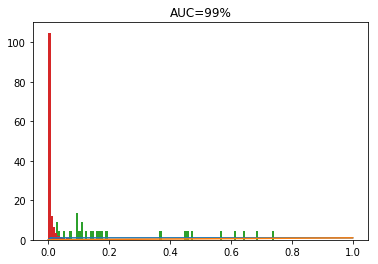

In [23]:
#######################
#### 测试GBDT的性能 ####
#######################
X_test,y_test = test_data[features], test_data['flag']
y_predprob = gbm_best.predict_proba(X_test)[:,1]
result = pd.DataFrame({'real':y_test,'pred':y_predprob})
ROC_AUC(result, 'pred', 'real')

result.groupby(['real'])['pred'].mean()
bad, good = result[result.real == 1],result[result.real == 0]
plt.hist(bad['pred'], bins = 100,normed=True)
plt.hist(good['pred'], bins = 100,normed=True)

## 2，在1的结果之上，利用feature_importances_估计变量的重要性，从中选取N个（N自取）最重要的模型构建SVM或者逻辑回归模型

In [29]:
from pandas import DataFrame
df = DataFrame({'imp':feature_importances,'features':features})
df.head()

,features,imp
0,certificationtype,0.001127
1,age,0.020677
2,registered_days,0.040712
3,area4_danger,0.044172
4,is_area3_eqaul_area4,0.000800


In [30]:
df_sorted = df.sort_values(by='imp', ascending=False)
df_sorted.head()

,features,imp
34,is_area9_equal_area6,0.117217
39,pay_amount,0.057588
45,12h_sign_bank_cnt,0.044685
3,area4_danger,0.044172
2,registered_days,0.040712


In [39]:
#选取前10个特征
train1 = train_data[df_sorted['features'][:10]]

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
LR = LogisticRegression().fit(train_data[df_sorted['features'][:10]],train_data['flag'])

In [42]:
pred = LR.predict_proba(train_data[df_sorted['features'][:10]])
pred

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


array([[9.99733371e-01, 2.66629331e-04],
       [1.00000000e+00, 2.00708718e-67],
       [9.34451638e-01, 6.55483620e-02],
       ...,
       [9.97602790e-01, 2.39721025e-03],
       [9.79826972e-01, 2.01730276e-02],
       [9.99999970e-01, 3.03102537e-08]])

In [45]:
from sklearn import metrics
pred1 = LR.predict_proba(test_data[df_sorted['features'][:10]])[:,1]
metrics.roc_auc_score(test_data['flag'], pred1)

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.6542600235849056

### end

### end

### end

### end

### end

### end

### end

### end